In [1]:
using Plots
using LinearAlgebra
using Vec
using GLPK
using JuMP
gr()

Plots.GRBackend()

In [2]:
function run_descent_method(descent_method, initial_point, steps, f, df)
    
    current_point = initial_point
    pointsX = [initial_point[1]]
    pointsY = [initial_point[2]]
    
    for i in 1 : steps
        current_step = step!(descent_method, df, current_point)
        push!(pointsX, current_step[1])
        push!(pointsY, current_step[2])
        current_point = current_step
    end
    return pointsX, pointsY
end

run_descent_method (generic function with 1 method)

In [3]:
# Function to let us plot mulitple descent graphs at a time

function get_descent_plot(pts, name, color::String="black")
    Plots.Linear([P.x for P in pts], [P.y for P in pts], style="thick, $color, solid, mark=none, line join=round", legendentry=name) #$
end

get_descent_plot (generic function with 2 methods)

In [4]:
abstract type DescentMethod end
struct GradientDescent <: DescentMethod
    learning_rate # learning rate
end

function step!(self::GradientDescent, df, current_point)
    
    learning_rate, gradient = self.learning_rate, df(current_point[1],current_point[2])
    
    return current_point - learning_rate*gradient
end

step! (generic function with 1 method)

# Question 1 (25 points)

Consider the following binary integer program.
\begin{aligned}
& \text{Maximize } 12x_1 + x_2 + 10x_3 + 2x_4 \\
& \text{subject to:} \\
& 16x_1 + 2x_2 + 10x_3 + 8x_4 \leq 18 \\
& x_i \in \{0,1\} \text{ for } i=1, \dots, 4
\end{aligned}

Use the branch-and-bound method to find an optimal solution to this problem. You can
use Julia/JuMP and a solver to solve the LP relaxations of the subproblems resulting from
fixing some decision variables at 0 or 1. Fix the variables in the order x1,x2,x3,x4.

Let's start by fixing the variable x_1.
Fixing $x_1=0$
\begin{aligned}
& \text{Maximize } x_2 + 10x_3 + 2x_4 \\
& \text{subject to:} \\
& 2x_2 + 10x_3 + 8x_4 \leq 18 \\
& x_i \in \{0,1\} \text{ for } i=2, \dots, 4
\end{aligned}

In [5]:
model = Model(GLPK.Optimizer)  
@variable(model, x1==0)
@variable(model, 0 <= x2 <= 1)
@variable(model, 0 <= x3 <= 1)
@variable(model, 0 <= x4 <= 1)
# Constraints
@constraint(model, 2x2+10x3+8x4 <= 18)
# Objective Function:
@objective(model, Max,x2+10x3+2x4)
optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("x1-x4 value: $(value(x1)), $(value(x2)), $(value(x3)), $(value(x4))")
    println("objective value: ",objective_value(model))
elseif termination_status(model) == MOI.INFEASIBLE
    println("The model is infeasible")
else
    println("The model didn't solve properly for some other reason.")
end

x1-x4 value: 0.0, 1.0, 1.0, 0.75
objective value: 12.5


since x4 is 0.75, now we start by fixing the variable x_4.
Fixing $x_4=0$
\begin{aligned}
& \text{Maximize } x_2 + 10x_3\\
& \text{subject to:} \\
& 2x_2 + 10x_3\leq 18 \\
& x_i \in \{0,1\} \text{ for } i=2,3
\end{aligned}



In [6]:

model = Model(GLPK.Optimizer)  
@variable(model, x1==0)
@variable(model, 0 <= x2 <= 1)
@variable(model, 0 <= x3 <= 1)
@variable(model, x4==0)
# Constraints
@constraint(model, 2x2+10x3 <= 18)
# Objective Function:
@objective(model, Max,x2+10x3)
optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("x1-x4 value: $(value(x1)), $(value(x2)), $(value(x3)), $(value(x4))")
    println("objective value: ",objective_value(model))
elseif termination_status(model) == MOI.INFEASIBLE
    println("The model is infeasible")
else
    println("The model didn't solve properly for some other reason.")
end

x1-x4 value: 0.0, 1.0, 1.0, 0.0
objective value: 11.0


now we start by fixing the variable x_4.
Fixing $x_4=1$
\begin{aligned}
& \text{Maximize } x_2 + 10x_3+ 2\\
& \text{subject to:} \\
& 2x_2 + 10x_3 + 8\leq 18 \\
& x_i \in \{0,1\} \text{ for } i=2,3
\end{aligned}


In [7]:

model = Model(GLPK.Optimizer)  
@variable(model, x1==0)
@variable(model, 0 <= x2 <= 1)
@variable(model, 0 <= x3 <= 1)
@variable(model, x4==1)
# Constraints
@constraint(model, 2x2+10x3+8 <= 18)
# Objective Function:
@objective(model, Max,x2+10x3+2)
optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("x1-x4 value: $(value(x1)), $(value(x2)), $(value(x3)), $(value(x4))")
    println("objective value: ",objective_value(model))
elseif termination_status(model) == MOI.INFEASIBLE
    println("The model is infeasible")
else
    println("The model didn't solve properly for some other reason.")
end

x1-x4 value: 0.0, 0.0, 1.0, 1.0
objective value: 12.0


this node is done.
now lets fixing the variable x_1.
Fixing $x_1=1$
\begin{aligned}
& \text{Maximize } 12 + x_2 + 10x_3 + 2x_4 \\
& \text{subject to:} \\
& 16+ 2x_2 + 10x_3 + 8x_4 \leq 18 \\
& x_i \in \{0,1\} \text{ for } i=2, \dots, 4
\end{aligned}

In [8]:
model = Model(GLPK.Optimizer)  
@variable(model, x1==1)
@variable(model, 0 <= x2 <= 1)
@variable(model, 0 <= x3 <= 1)
@variable(model, 0 <= x4 <= 1)
# Constraints
@constraint(model, 16+2x2+10x3+8x4 <= 18)
# Objective Function:
@objective(model, Max,12+x2+10x3+2x4)
optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("x1-x4 value: $(value(x1)), $(value(x2)), $(value(x3)), $(value(x4))")
    println("objective value: ",objective_value(model))
elseif termination_status(model) == MOI.INFEASIBLE
    println("The model is infeasible")
else
    println("The model didn't solve properly for some other reason.")
end

x1-x4 value: 1.0, 0.0, 0.2, 0.0
objective value: 14.0


this node is done.
now lets fixing the variable x_1,x_3.
Fixing $x_1=1$
Fixing $x_3=0$

\begin{aligned}
& \text{Maximize } 12 + x_2 + 2x_4 \\
& \text{subject to:} \\
& 16+ 2x_2+ 8x_4 \leq 18 \\
& x_i \in \{0,1\} \text{ for } i=2,4
\end{aligned}

In [9]:
model = Model(GLPK.Optimizer)  
@variable(model, x1==1)
@variable(model, 0 <= x2 <= 1)
@variable(model, x3==0)
@variable(model, 0 <= x4 <= 1)
# Constraints
@constraint(model, 16+2x2+8x4 <= 18)
# Objective Function:
@objective(model, Max,12+x2+2x4)
optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("x1-x4 value: $(value(x1)), $(value(x2)), $(value(x3)), $(value(x4))")
    println("objective value: ",objective_value(model))
elseif termination_status(model) == MOI.INFEASIBLE
    println("The model is infeasible")
else
    println("The model didn't solve properly for some other reason.")
end

x1-x4 value: 1.0, 1.0, 0.0, 0.0
objective value: 13.0


the solution was good
now lets fixing the variable x_1,x_3.
Fixing $x_1=1$
Fixing $x_3=1$

\begin{aligned}
& \text{Maximize } 12 + x_2 +10 + 2x_4 \\
& \text{subject to:} \\
& 16+ 2x_2+10+ 8x_4 \leq 18 \\
& x_i \in \{0,1\} \text{ for } i=2,4
\end{aligned}

In [10]:
model = Model(GLPK.Optimizer)  
@variable(model, x1==1)
@variable(model, 0 <= x2 <= 1)
@variable(model, x3==1)
@variable(model, 0 <= x4 <= 1)
# Constraints
@constraint(model, 16+2x2+10+8x4 <= 18)
# Objective Function:
@objective(model, Max,12+x2+10+2x4)
optimize!(model)

if termination_status(model) == MOI.OPTIMAL
    println("x1-x4 value: $(value(x1)), $(value(x2)), $(value(x3)), $(value(x4))")
    println("objective value: ",objective_value(model))
elseif termination_status(model) == MOI.INFEASIBLE
    println("The model is infeasible")
else
    println("The model didn't solve properly for some other reason.")
end

The model is infeasible


now we have 
x1-x4 value: 1.0, 1.0, 0.0, 0.0
objective value: 13.0
which is the optimal solution for this quesiton.

# Question 2 (25 points)

Consider the knapsack problem where you can fill your knapsack with one or more of the
six items C1-C6. You want to maximise the utility of items in your
knapsack, but the total weight of the knapsack can be at most 15 Kg. The value and the
weight associated with each of the items are given in the table below:

Utility4 2 1 7 3 6  
Weight 5 8 8 6 1 5  
Unlike the classical knapsack problem, you also have another constraint -- You want to
pick at least three items. Formulate this problem as an Integer Linear Program and solve it
using Julia/JuMP and one of your solvers.

First we make a objective function  

\begin{aligned}
& \text{Maximize } 4x_1+ 2x_2 + x_3 + 7x_4 + 3x_5 + 6x_6 \\
& \text{subject to:} \\
& 5x_1 + 8x_2 + 8x_3 + 6x_4 + x_5 + 5x_6 \leq 15 \\
& x_i \in [0,1] \text{ for } i=1, \dots, 6 \\
\end{aligned}

should choose at least 3 items

In [11]:
model = Model(GLPK.Optimizer)

@variable(model, x[1:6]>=0,Int)
@variable(model, y[1:6], Bin) # y here means number of item i is picked or not,with binary value yes or no

@objective(model, Max, 4x[1] + 2x[2] + x[3] + 7x[4] + 3x[5] + 6x[6])

@constraint(model, 5x[1] + 8x[2] + 8x[3] + 6x[4] + x[5] + 5x[6] ≤ 15)


for i in 1:6
    @constraint(model, x[i] <= y[i]) # if y[i] = 1 (be selected), x[i] = 0 or 1
end
@constraint(model, sum(y[i] for i in 1:6) ≥ 3)

optimize!(model)

solution = value.(x)
println("Optimal solution: ", solution)
println("Maximum utility: ", objective_value(model))

Optimal solution: [0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Maximum utility: 16.0


The best solution for this is select C4,C5,C6 these 3 items, which has maximum utility 16 and weight is 12 which also less than 15 to satisfy the weight constraint.

# Question3
our task is to minimise the following two multivariate functions using the convex optimisation techniques that you learnt in the module.  
f1(x, y) = (1− x)^2 + 5 * (y− 2 * x^2)^2  
f2(x, y) = x^2 + y^2 + x * y + 5  
For the first function, use the starting point (-1,2) and for the second function, use the
starting point (-3,1.5). Then, compare the performance of Gradient Descent, Momentum,
Nesterov Momentum and Adam optimiser for these tasks. For the first function, you can
use 100 steps and for the second function, use 50 steps of all these techniques. For each
of these techniques, use the best from two different learning rates: 0.01 and 0.001 for the
first function and from 0.1 and 0.01 for the second function. You can find good values of
other parameters empirically. Plot the contour lines and show the iterative progress made
by the different optimisation techniques (just as you did in your tutorial). How do these
techniques compare empirically? Do you observe any benefit of Adam over other
techniques for these functions?

In [12]:
mutable struct Momentum <: DescentMethod
    learning_rate # learning rate
    momentum_decay # momentum decay
    momentum # momentum
end

function step!(self::Momentum, df, current_point)
    
    learning_rate, momentum_decay = self.learning_rate, self.momentum_decay
    
    momentum, gradient= self.momentum, df(current_point[1],current_point[2])
    
    self.momentum = momentum_decay*momentum .- learning_rate*gradient
    
    return current_point .+ self.momentum
end

step! (generic function with 2 methods)

In [13]:
mutable struct NesterovMomentum <: DescentMethod
    learning_rate # learning rate
    momentum_decay # momentum decay
    momentum # momentum
end

function step!(self::NesterovMomentum, df, current_point)
    
    learning_rate, momentum_decay = self.learning_rate, self.momentum_decay
    momentum = self.momentum
    
    nesterov = current_point .+ momentum_decay*momentum
    
    gradient = df(nesterov[1],nesterov[2])
    
    self.momentum = momentum_decay*momentum .- learning_rate*gradient
    
    return current_point .+ self.momentum 
end

step! (generic function with 3 methods)

In [14]:
mutable struct Adam <: DescentMethod
    learning_rate # learning rate
    decay_v # decay_v
    decay_s # decay_s
    epsilon # small value
    counter # step counter
    v # 1st moment estimate
    s # 2nd moment estimate
end

function step!(self::Adam, df, current_point)
    
    learning_rate, decay_v = self.learning_rate, self.decay_v
    decay_s, epsilon, = self.decay_s, self.epsilon
    counter = self.counter
    s, v = self.s, self.v
    
    gradient = df(current_point[1],current_point[2])
    
    v[:] = decay_v*v .+ (1-decay_v)*gradient
    s[:] = decay_s*s .+ (1-decay_s)*gradient.*gradient
    
    self.counter = counter += 1
    v_hat = v ./ (1 - decay_v^counter)
    s_hat = s ./ (1 - decay_s^counter)
    
    return current_point .- learning_rate*v_hat ./ (sqrt.(s_hat) .+ epsilon)
end

step! (generic function with 4 methods)

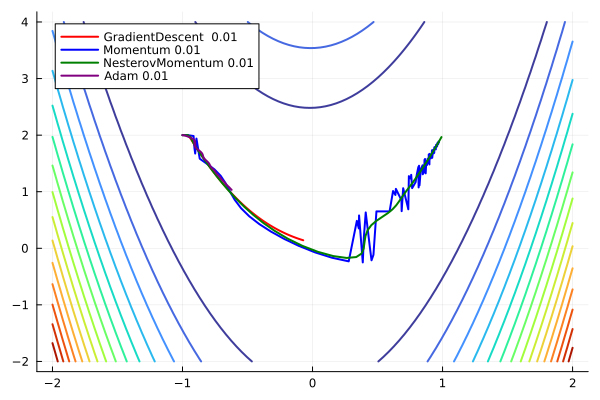

In [61]:
using Plots 
f(x,y) = (1 - x)^2 + 5 * (y- 2 * x^2)^2
df(x,y) = [
    -2 * (1 - x) - 20 * x * (y - 2 * x^2),10 * (y - 2 * x^2)
]
xDomain = range(-2, 2, length=100)
yDomain = range(-2, 4, length=100)
zFill = @. f(xDomain', yDomain)

descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (GradientDescent(0.01), "GradientDescent  0.01", "red", 100, (-1,2)))
push!(descent_methods, (Momentum(0.01,0.9,zeros(2)), "Momentum 0.01", "blue", 100, (-1,2)))
push!(descent_methods, (NesterovMomentum(0.01,0.9,zeros(2)), "NesterovMomentum 0.01", "green", 100, (-1,2)))
push!(descent_methods, (Adam(0.01, 0.9, 0.9, 1e-8, 0, zeros(2), zeros(2)), "Adam 0.01", "purple",100,(-1,2)))

plots = contour(xDomain, yDomain, zFill,cbar=false,color=:turbo,lw=2)
    
for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
    pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
    plot!(pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
end 
plot(plots)

Global minimum is (1,2)

The Gradient Descent path suggests a straight like path, maybe because of its constant step size, which may cause it to take longer before it can finally converge. Momentum shows better progress at first, oscillates, and continues through its velocity component, but there is every suggestion that overshoot of the minimum is probable as momentum accumulates.

This path with its correction look-ahead mechanism is observed with a Nesterov Momentum trying to reduce the overshooting witnessed with Momentum and has, of course, a more efficient path to the minimum. However, it still exhibits some oscillations, which may slow the convergence down at or just before hitting the minimum.

The Adam optimizer is characterized by its very smooth and straight trajectory toward the minimum. It enjoys the benefits of adaptive learning rates and momentum-like features to make the updates of the function geometry flexible and responsive. This adaptation is seen by the oscillation of the minimum along its trajectory, which means controlled and smooth convergence.

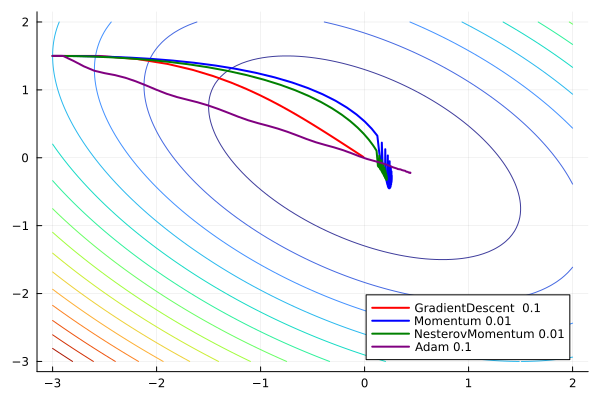

In [57]:
using Plots 
f(x, y) = x^2 + y^2 + x * y + 5
df(x,y) = [
    2x + y, 2y + x
]
xDomain = range(-3, 2, length=100)
yDomain = range(-3, 2, length=100)
zFill = @. f(xDomain', yDomain)
    

descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (GradientDescent(0.1), "GradientDescent  0.1", "red", 50, (-3,1.5)))
push!(descent_methods, (Momentum(0.01,0.9,zeros(2)), "Momentum 0.01", "blue", 50, (-3,1.5)))
push!(descent_methods, (NesterovMomentum(0.01,0.9,zeros(2)), "NesterovMomentum 0.01", "green", 50, (-3,1.5)))
push!(descent_methods, (Adam(0.1, 0.9, 0.9, 1e-8, 0, zeros(2), zeros(2)), "Adam 0.1", "purple",50,(-3,1.5)))

plots = contour(xDomain, yDomain, zFill,cbar=false,color=:turbo,lw=1)
    
for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
    pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
    plot!(pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
end 
plot(plots)

(0,0)

Gradient Descent is direct but moving potentially slower, which clearly signifies that it would take many iterations in order to have it converge, especially with a small learning rate.  
The momentum path towards the minimum due to the added inertia gives a rising acceleration of convergence, but it can overrun due to accumulated momentum and cause oscillations around the minimum.  
Nesterov Momentum is a standard improvement of the Momentum method. Look-ahead is added: it adjusts the update by where the next step would land, and so in foresight. This brings about a decrease in overshooting, usually leading to faster convergence. This can be seen in slightly tighter trajectories around the minimum compared to Momentum.  
Differentiated is the trajectory of Adam, which corrects its path in a much more stable manner than the other two and shows a settled-down convergence pattern. This probably allows it to navigate through the contours of the function using adaptive learning rates based on the first and second moments of gradients.  

Adam's shows that it falls near the minimum with fewer oscillations, meaning it takes in the characteristics of both the stability of gradient descent and the acceleration of momentum. The adaptive mechanism of Adam appears to possess strong properties of convergence for this function, steering well over the parameter space with efficient sensitivity to the initial settings of hyperparameters. This has an obvious empirical advantage in terms of speed and stability of convergence and thus makes it a very good candidate for the task of optimization.